In [1]:
import torch

In [2]:
x = torch.arange(10)
x

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [3]:
x.shape

torch.Size([10])

In [4]:
x.numel()

10

In [5]:
y = torch.ones([3,4])
y

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [6]:
y.numel()

12

In [7]:
torch.randn((3,4))

tensor([[ 0.4719,  0.2291, -0.4568, -0.6615],
        [ 1.3411, -0.6571,  0.0271,  0.8877],
        [ 0.4201,  1.1844,  0.0313,  0.9742]])

In [8]:
torch.tensor([[1,2],[3,4],[5,6]])

tensor([[1, 2],
        [3, 4],
        [5, 6]])

## 3.2. 线性回归的从零开始实现

In [9]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [10]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.1, y.shape)
    return X, y.reshape((-1, 1))

In [11]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [12]:
features[:10,:],labels[:10]

(tensor([[ 2.0467,  1.5057],
         [-0.0886,  0.3626],
         [ 0.5622,  0.7358],
         [ 0.5038,  1.2219],
         [-0.8239,  1.3115],
         [ 0.4176, -1.3122],
         [ 0.3090,  2.3168],
         [-0.5541, -0.7964],
         [ 0.1517, -0.5129],
         [ 0.5870,  0.7911]]),
 tensor([[ 3.3607],
         [ 2.9202],
         [ 2.7461],
         [ 1.1843],
         [-1.8804],
         [ 9.5576],
         [-3.0881],
         [ 5.8984],
         [ 6.1932],
         [ 2.6552]]))

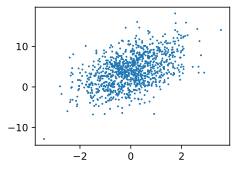

In [13]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 0].detach().numpy(), labels.detach().numpy(), 1);

In [14]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [15]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.2042, -0.8257],
        [ 1.9347,  0.2196],
        [ 1.0361, -0.4245],
        [-0.0281,  1.7834],
        [ 0.3852, -0.2577],
        [-0.7385, -1.3258],
        [ 0.6561,  0.8703],
        [-0.2612,  1.0620],
        [-0.0944, -0.4780],
        [-0.6083, -0.6987]]) 
 tensor([[ 7.5427],
        [ 7.2467],
        [ 7.6158],
        [-1.9689],
        [ 5.6552],
        [ 7.3219],
        [ 2.5067],
        [ 0.1802],
        [ 5.7125],
        [ 5.2900]])


In [16]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [17]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [18]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [19]:
lr = 0.005
num_epochs = 3
net = linreg
loss = squared_loss

w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
#     with torch.no_grad():
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 6.079360
epoch 2, loss 2.301343
epoch 3, loss 0.873306


In [20]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.4547, -0.7700], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.9899], grad_fn=<RsubBackward1>)


## 3.5. 图像分类数据集

In [23]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [24]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [25]:
!ls

test1.ipynb


In [26]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [27]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [28]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [30]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

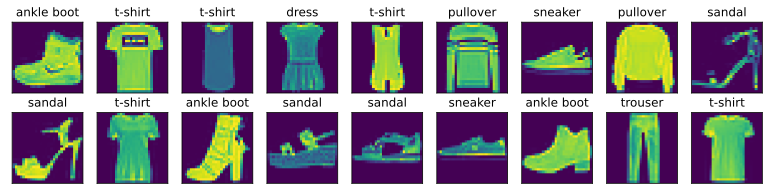

In [31]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))